In [78]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from scipy import stats
from scipy.ndimage import gaussian_filter
from dataclasses import dataclass
from typing import Tuple, Dict
from typing import Dict, Tuple, List, Optional

from scipy.spatial.distance import cdist
import odor_stat_calculations as osc
from plume_sim import ParallelOdorPredictor
from scipy.stats import kurtosis
import matplotlib.pyplot as plt 
import seaborn as sns
from figurefirst import mpl_functions
import sys
sys.path.append("../")
from cfd_rigolli import Cfd_rigolli
from plume_sim_batch import ParallelOdorPredictor as BatchPredictor
from mpl_toolkits.axes_grid1 import make_axes_locatable
import multiprocessing as mp


## trajectory classification and clustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tsfresh import extract_features
from tsfresh.feature_extraction import MinimalFCParameters  # Import minimal settings
from tsfresh.utilities.dataframe_functions import impute
from sklearn.metrics import silhouette_score

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [79]:
class SurgeCastAgent:
    def __init__(self, tau=0.42, noise=1.9, bias=0.25, threshold=4.5,
                 hit_trigger='peak', surge_amp=2.0, tau_surge=0.5,
                 cast_freq=1.0, cast_width=0.8, bounds=None):
        self.tau = tau
        self.noise = noise
        self.bias = bias
        self.threshold = threshold
        self.hit_trigger = hit_trigger
        self.surge_amp = surge_amp
        self.tau_surge = tau_surge
        self.cast_freq = cast_freq
        self.cast_width = cast_width
        self.bounds = bounds
        self.surge_amp_ = surge_amp / (tau_surge * np.exp(-1))

    def reflect_if_out_of_bounds(self, v: np.ndarray, x: np.ndarray):
        if self.bounds is None:
            return v, x
        v_new = v.copy()
        x_new = x.copy()
        for dim in range(2):
            if x[dim] < self.bounds[dim][0]:
                v_new[dim] *= -1
                x_new[dim] = 2*self.bounds[dim][0] - x[dim]
            elif x[dim] > self.bounds[dim][1]:
                v_new[dim] *= -1
                x_new[dim] = 2*self.bounds[dim][1] - x[dim]
        return v_new, x_new

def tracking(predictor, bounds, start_pos, target_pos, surge_agent, 
          target_weight, plume_timeout, closest_to_source, duration):
    dt = 0.005
    n_steps = int(duration / dt)

    # Original arrays
    ts = np.arange(n_steps)*dt
    odors = np.zeros(n_steps)
    surges = np.zeros(n_steps)
    bs = np.zeros((n_steps,2))
    vs = np.zeros((n_steps,2))
    xs = np.zeros((n_steps,2))
    hits = np.zeros(n_steps)
    
    # New arrays for additional metrics
    velocities = np.zeros((n_steps,2))  # Velocity vector
    speeds = np.zeros(n_steps)          # Speed magnitude
    accelerations = np.zeros(n_steps)   # Acceleration magnitude
    angles = np.zeros(n_steps)          # Heading angle
    angular_velocities = np.zeros(n_steps)  # Rate of turning
    crosswind_distances = np.zeros(n_steps) # Distance perpendicular to wind
    upwind_distances = np.zeros(n_steps)    # Distance parallel to wind
    dist_to_targets = np.zeros(n_steps)     # Distance to target
    time_since_last_hits = np.zeros(n_steps) # Time since last whiff
    casting_phases = np.zeros(n_steps)      # Phase of casting motion
    local_curvatures = np.zeros(n_steps)    # Path curvature

    x = start_pos.copy()
    v = np.zeros(2)
    last_hit_time = -np.inf
    last_odor = 0
    hit_occurred = False
    prev_angle = 0

    # Initial bias calculation remains same
    to_target = target_pos - x
    to_target /= (np.linalg.norm(to_target) + 1e-6)
    upwind = np.array([-1.0, 0.0])
    b = (1 - target_weight)*upwind + target_weight*to_target
    b *= (surge_agent.bias / np.linalg.norm(b))

    for t_ctr in range(n_steps):
        current_odor = predictor.step_update(x[0], x[1], dt)
        odors[t_ctr] = current_odor

        # Original hit detection logic
        if surge_agent.hit_trigger == 'peak':
            if current_odor >= surge_agent.threshold:
                if current_odor <= last_odor and not hit_occurred:
                    hits[t_ctr] = 1
                    hit_occurred = True
                    last_hit_time = t_ctr*dt
                    remaining_steps = n_steps - t_ctr
                    ts_ = ts[:remaining_steps] - ts[0]
                    surge_force = surge_agent.surge_amp_ * ts_ * np.exp(-ts_/surge_agent.tau_surge)
                    surges[t_ctr:] = np.minimum(surge_force, 50.0)
                last_odor = current_odor
            else:
                last_odor = 0
                hit_occurred = False

        if t_ctr > 0:
            # Original movement logic
            eta = np.random.normal(0, surge_agent.noise, 2)
            time_since_hit = (t_ctr*dt - last_hit_time)
            to_target = target_pos - x
            dist_to_target = np.linalg.norm(to_target)
            
            if dist_to_target < closest_to_source:
                print(f"Target reached at {x}")
                break
                
            to_target /= (dist_to_target + 1e-6)

            current_target_weight = target_weight
            if time_since_hit > plume_timeout:
                current_target_weight = min(0.8, 
                    target_weight + 0.1*(time_since_hit - plume_timeout)/plume_timeout)

            if surges[t_ctr] > 1.0:
                surge_direction = np.array([-1.0, -0.05*x[1]])
                surge_direction /= np.linalg.norm(surge_direction)
                b = (1 - current_target_weight)*surge_direction + current_target_weight*to_target
                b *= surges[t_ctr]
            else:
                cast_freq = 0.5
                cast_phase = np.sin(2*np.pi*cast_freq*ts[t_ctr])
                base_cast_width = 1.0
                dist_factor = min(1.0, dist_to_target/20.0)
                cast_width = base_cast_width*dist_factor

                crosswind = np.array([0.0, cast_phase*cast_width])
                upwind = np.array([-0.2, 0.0])
                b = (1 - current_target_weight)*(upwind + crosswind) + current_target_weight*to_target
                norm_b = np.linalg.norm(b)
                if norm_b > 0:
                    b *= surge_agent.bias/norm_b

            # Update velocity and position
            v += (dt/surge_agent.tau)*(-v + eta + b)
            x += v*dt
            v, x = surge_agent.reflect_if_out_of_bounds(v, x)

            # Calculate additional metrics
            velocities[t_ctr] = v
            speeds[t_ctr] = np.linalg.norm(v)
            if t_ctr > 0:
                accelerations[t_ctr] = (speeds[t_ctr] - speeds[t_ctr-1])/dt
            
            # Heading angle and angular velocity
            current_angle = np.arctan2(v[1], v[0])
            angles[t_ctr] = current_angle
            if t_ctr > 0:
                angle_diff = np.arctan2(np.sin(current_angle - prev_angle),
                                      np.cos(current_angle - prev_angle))
                angular_velocities[t_ctr] = angle_diff/dt
            prev_angle = current_angle
            
            # Distance components
            crosswind_distances[t_ctr] = abs(x[1] - target_pos[1])
            upwind_distances[t_ctr] = abs(x[0] - target_pos[0])
            dist_to_targets[t_ctr] = dist_to_target
            time_since_last_hits[t_ctr] = time_since_hit
            casting_phases[t_ctr] = cast_phase
            
            # Path curvature (for segments of 3 points)
            if t_ctr >= 2:
                pos_window = xs[t_ctr-2:t_ctr+1]
                dx = np.gradient(pos_window[:,0])
                dy = np.gradient(pos_window[:,1])
                ddx = np.gradient(dx)
                ddy = np.gradient(dy)
                curvature = np.abs(dx*ddy - dy*ddx) / (dx**2 + dy**2)**1.5
                local_curvatures[t_ctr] = np.mean(curvature)

        # Store original metrics
        bs[t_ctr] = b
        vs[t_ctr] = v
        xs[t_ctr] = x

    # Trim if ended early
    if t_ctr < (n_steps-1):
        trim_slice = slice(0, t_ctr+1)
        ts = ts[trim_slice]
        xs = xs[trim_slice]
        bs = bs[trim_slice]
        vs = vs[trim_slice]
        odors = odors[trim_slice]
        hits = hits[trim_slice]
        surges = surges[trim_slice]
        velocities = velocities[trim_slice]
        speeds = speeds[trim_slice]
        accelerations = accelerations[trim_slice]
        angles = angles[trim_slice]
        angular_velocities = angular_velocities[trim_slice]
        crosswind_distances = crosswind_distances[trim_slice]
        upwind_distances = upwind_distances[trim_slice]
        dist_to_targets = dist_to_targets[trim_slice]
        time_since_last_hits = time_since_last_hits[trim_slice]
        casting_phases = casting_phases[trim_slice]
        local_curvatures = local_curvatures[trim_slice]

    # Create complete DataFrame
    trajectory_df = pd.DataFrame({
        'time': ts,
        'x': xs[:,0],
        'y': xs[:,1],
        'vx': velocities[:,0],
        'vy': velocities[:,1],
        'speed': speeds,
        'acceleration': accelerations,
        'heading_angle': angles,
        'angular_velocity': angular_velocities,
        'crosswind_dist': crosswind_distances,
        'upwind_dist': upwind_distances,
        'dist_to_target': dist_to_targets,
        'time_since_whiff': time_since_last_hits,
        'casting_phase': casting_phases,
        'path_curvature': local_curvatures,
        'odor': odors,
        'whiff': hits,
        'surge_force': surges,
        'bias_force_x': bs[:,0],
        'bias_force_y': bs[:,1]
    })
    
    xs[t_ctr] = target_pos
    fig, axs = plt.subplots(3,1,figsize=(8,8))
    axs[0].plot(xs[:,0], xs[:,1],'b-', label='Path')
    axs[0].plot(start_pos[0], start_pos[1], 'go', label='Start')
    axs[0].plot(target_pos[0], target_pos[1], 'ro', label='Target')
    whiff_idx = np.where(hits==1)[0]
    if len(whiff_idx)>0:
        axs[0].plot(xs[whiff_idx,0], xs[whiff_idx,1], 'g*', label='Whiffs')
    axs[0].set_title(f'Trajectory (Whiffs: {np.sum(hits)})')
    axs[0].legend()

    axs[1].plot(ts, odors, 'b-', label='Odor')
    if len(whiff_idx)>0:
        axs[1].plot(ts[whiff_idx], odors[whiff_idx], 'r*', label='Detected Whiffs')
    axs[1].axhline(surge_agent.threshold, color='r', linestyle='--', label='Threshold')
    axs[1].legend()
    axs[1].set_title('Odor concentration')

    axs[2].plot(ts, np.linalg.norm(bs,axis=1),'g-', label='Bias Force')
    axs[2].plot(ts, surges, 'r-', label='Surge Force')
    axs[2].legend()
    axs[2].set_title('Control Forces')
    fig.suptitle('my odor simulator')
    fig.tight_layout()
    
    return trajectory_df

Target reached at [5.02909962 3.8025168 ]


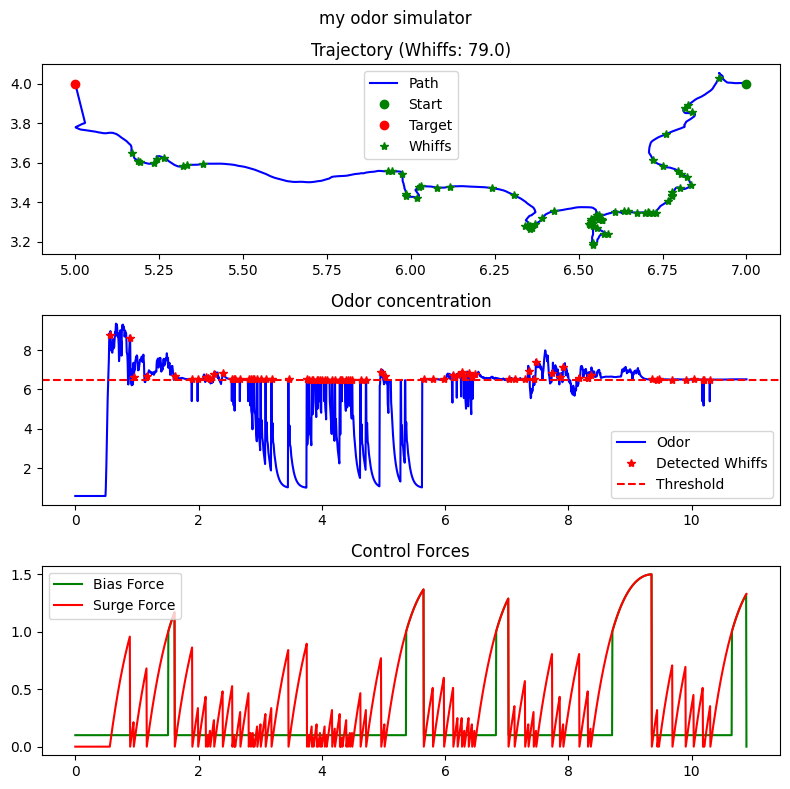

In [114]:
if __name__ == "__main__":
    # Setup simulation parameters
    bounds = [(5, 40), (0, 8)]
    start_pos = np.array([7.0, 4.0])
    target_pos = np.array([5.0, 4.0])
    
    surge_agent = SurgeCastAgent(
        tau=0.3,
        noise=3.0,
        bias=0.1,
        threshold=6.5,
        hit_trigger='peak',
        surge_amp=1.5,
        tau_surge=1.0,
        bounds=bounds
    )
    
    target_weight = 0
    plume_timeout = 10.0
    closest_to_source = 0.2
    sim_duration = 50.0
    
    dirname = '../data/simulator/rigolli/'
    hmap_data = np.load(str(dirname) + "hmap.npz")
    fdf = pd.read_hdf(str(dirname) + 'whiff.h5')
    fdf_nowhiff = pd.read_hdf(str(dirname) + 'nowhiff.h5')

    # 2) Create predictor (no df_test needed for real-time)
    predictor = ParallelOdorPredictor(
        fitted_p_heatmap=hmap_data['fitted_p_heatmap'],
        xedges=hmap_data['xedges'],
        yedges=hmap_data['yedges'],
        fdf=fdf,
        fdf_nowhiff=fdf_nowhiff
    )

    osdf=pd.DataFrame()
    osdf= tracking(predictor, bounds, start_pos,target_pos,surge_agent, target_weight,
        plume_timeout, closest_to_source, sim_duration )

In [255]:
# osdf.to_hdf('/home/gorilla/An/data/simulator/plot/tracking_figure/os8.h5', mode='w',key='osdf')
# test=pd.read_hdf('/home/gorilla/An/data/simulator/plot/tracking_figure/os8.h5')
# test

,time,x,y,vx,vy,speed,acceleration,heading_angle,angular_velocity,crosswind_dist,upwind_dist,dist_to_target,time_since_whiff,casting_phase,path_curvature,odor,whiff,surge_force,bias_force_x,bias_force_y
0,0.000,7.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000e+00,0.600000,0.0,0.000000,-0.100000,0.000000
1,0.005,7.000013,4.000089,0.002623,0.017714,0.017907,3.581396,1.423794,284.758759,0.000089,2.000013,2.000000,inf,0.015707,0.000000e+00,0.600000,0.0,0.000000,-0.100000,0.000037
2,0.010,7.000033,3.999935,0.004050,-0.030781,0.031046,2.627885,-1.439984,-572.755647,0.000065,2.000033,2.000013,inf,0.031411,1.317826e+08,0.600000,0.0,0.000000,-0.100000,0.000071
3,0.015,6.999887,4.000237,-0.029357,0.060552,0.067293,7.249409,2.022231,-564.193991,0.000237,1.999887,2.000033,inf,0.047106,5.161073e+07,0.600000,0.0,0.000000,-0.100000,0.000115
4,0.020,6.999875,4.000417,-0.002385,0.035926,0.036005,-6.257618,1.637076,-77.030988,0.000417,1.999875,1.999887,inf,0.062791,1.184196e+07,0.600000,0.0,0.000000,-0.100000,0.000138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2174,10.870,5.026990,3.799919,0.303995,0.161934,0.344435,-6.004447,0.489453,11.422901,0.200081,0.026990,0.202499,0.565,0.891007,6.389574e+04,6.515717,0.0,1.309356,-1.286354,-0.244350
2175,10.875,5.028184,3.800804,0.238888,0.177003,0.297317,-9.423612,0.637681,29.645557,0.199196,0.028184,0.201894,0.570,0.891007,5.565331e+04,6.515718,0.0,1.314355,-1.291256,-0.245333
2176,10.880,5.028746,3.801724,0.112291,0.184098,0.215642,-16.334960,1.023089,77.081634,0.198276,0.028746,0.201180,0.575,0.891007,4.556546e+03,6.515719,0.0,1.319272,-1.296075,-0.246306
2177,10.885,5.029100,3.802517,0.070801,0.158559,0.173648,-8.398709,1.150832,25.548695,0.197483,0.029100,0.200349,0.580,0.891007,3.316700e+05,6.515720,0.0,1.324107,-1.300814,-0.247267


In [340]:
# dirname = '../data/simulator/rigolli/'
# hmap_data = np.load(str(dirname) + "hmap.npz")
# test_locations = osdf[['x', 'y']].values
# fitted_p_heatmap = hmap_data['fitted_p_heatmap']
# xedges = hmap_data['xedges']
# yedges = hmap_data['yedges']
# predictorBatch = BatchPredictor(
#     fitted_p_heatmap=fitted_p_heatmap,
#     xedges=xedges,
#     yedges=yedges,
#     fdf=fdf,
#     fdf_nowhiff=fdf_nowhiff,
#     test_locations=test_locations
# )
# results = predictorBatch.predict()
# osdf['concentration']=results['concentrations']
# plt.plot(osdf.time, results['concentrations'])

### Rigolli Tracker

In [241]:
class CfdOdorPredictor:
    def __init__(self, cfd_simulator, scale_data_fn):
        self.cfd = cfd_simulator
        self.scale_data = scale_data_fn
        self.config = type('Config', (), {
            'warmup_steps': 0,
            'rows_per_second': 200
        })()

    def get_wind_at_position(self, pos: Tuple[float, float], time: float) -> Tuple[float, float, float]:
        return self.cfd.get_wind_at_position_and_time(pos, time)

    def get_odor_at_position(self, pos: Tuple[float, float], time: float) -> float:
        odor = self.cfd.get_odor_at_position_and_time(pos, time)
        return odor


def scale_data(data):
    min_val = 0
    max_val = 14
    return (((data - min_val) / (max_val - min_val)) * 10)
def cfd_tracking(
    cfd_predictor,
    bounds,
    start_pos,
    target_pos,
    surge_agent,
    target_weight,
    plume_timeout,
    closest_to_source,
    duration
):
    dt = 0.005
    n_steps = int(duration / dt)

    # Time and basic arrays
    ts = np.arange(n_steps)*dt
    scaled_odors = np.zeros(n_steps)
    surges = np.zeros(n_steps)
    bs = np.zeros((n_steps,2))
    vs = np.zeros((n_steps,2))
    xs = np.zeros((n_steps,2))
    hits = np.zeros(n_steps)

    # Additional metric arrays
    velocities = np.zeros((n_steps,2))  # Velocity vector
    speeds = np.zeros(n_steps)          # Speed magnitude
    accelerations = np.zeros(n_steps)   # Acceleration magnitude
    angles = np.zeros(n_steps)          # Heading angle
    angular_velocities = np.zeros(n_steps)  # Rate of turning
    crosswind_distances = np.zeros(n_steps) # Distance perpendicular to wind
    upwind_distances = np.zeros(n_steps)    # Distance parallel to wind
    dist_to_targets = np.zeros(n_steps)     # Distance to target
    time_since_last_hits = np.zeros(n_steps) # Time since last whiff
    casting_phases = np.zeros(n_steps)      # Phase of casting motion
    local_curvatures = np.zeros(n_steps)    # Path curvature

    x = start_pos.copy()
    v = np.zeros(2)
    last_hit_time = -np.inf
    last_odor = 0
    hit_occurred = False
    prev_angle = 0

    # Initial bias
    to_target = target_pos - x
    to_target /= (np.linalg.norm(to_target) + 1e-6)
    upwind = np.array([-1.0, 0.0])
    b = (1 - target_weight)*upwind + target_weight*to_target
    b *= (surge_agent.bias / np.linalg.norm(b))

    for t_ctr in range(n_steps):
        # Get odor
        raw_odor = cfd_predictor.get_odor_at_position(tuple(x), ts[t_ctr])
        current_odor = cfd_predictor.scale_data(raw_odor)
        scaled_odors[t_ctr] = current_odor

        # Whiff detection
        if surge_agent.hit_trigger == 'peak':
            if current_odor >= surge_agent.threshold:
                if current_odor <= last_odor and not hit_occurred:
                    hits[t_ctr] = 1
                    hit_occurred = True
                    last_hit_time = t_ctr*dt
                    remaining_steps = n_steps - t_ctr
                    ts_ = ts[:remaining_steps] - ts[0]
                    surge_force = surge_agent.surge_amp_ * ts_ * np.exp(-ts_/surge_agent.tau_surge)
                    surges[t_ctr:] = np.minimum(surge_force, 50.0)
                last_odor = current_odor
            else:
                last_odor = 0
                hit_occurred = False

        if t_ctr > 0:
            # Movement logic
            eta = np.random.normal(0, surge_agent.noise, 2)
            time_since_hit = (t_ctr*dt - last_hit_time)

            to_target = target_pos - x
            dist_to_target = np.linalg.norm(to_target)
            if dist_to_target < closest_to_source:
                print(f"Target reached at {x}")
                break
            to_target /= (dist_to_target + 1e-6)

            current_target_weight = target_weight
            if time_since_hit > plume_timeout:
                current_target_weight = min(
                    0.8, 
                    target_weight + 0.1*(time_since_hit - plume_timeout)/plume_timeout
                )

            # Movement mode (surge or cast)
            if surges[t_ctr] > 1.0:
                surge_direction = np.array([-1.0, -0.05*x[1]])
                surge_direction /= np.linalg.norm(surge_direction)
                b = (1 - current_target_weight)*surge_direction + current_target_weight*to_target
                b *= surges[t_ctr]
            else:
                cast_freq = 0.5
                cast_phase = np.sin(2*np.pi*cast_freq*ts[t_ctr])
                base_cast_width = 1.0
                dist_factor = min(1.0, dist_to_target/20.0)
                cast_width = base_cast_width*dist_factor

                crosswind = np.array([0.0, cast_phase*cast_width])
                upwind = np.array([-0.2, 0.0])
                b = (1 - current_target_weight)*(upwind + crosswind) + current_target_weight*to_target
                norm_b = np.linalg.norm(b)
                if norm_b > 0:
                    b *= surge_agent.bias/norm_b

            # Update position and velocity
            v += (dt/surge_agent.tau)*(-v + eta + b)
            x += v*dt
            v, x = surge_agent.reflect_if_out_of_bounds(v, x)

            # Calculate metrics
            velocities[t_ctr] = v
            speeds[t_ctr] = np.linalg.norm(v)
            if t_ctr > 0:
                accelerations[t_ctr] = (speeds[t_ctr] - speeds[t_ctr-1])/dt
            
            # Heading angle and angular velocity
            current_angle = np.arctan2(v[1], v[0])
            angles[t_ctr] = current_angle
            if t_ctr > 0:
                angle_diff = np.arctan2(np.sin(current_angle - prev_angle),
                                      np.cos(current_angle - prev_angle))
                angular_velocities[t_ctr] = angle_diff/dt
            prev_angle = current_angle
            
            # Distance metrics
            crosswind_distances[t_ctr] = abs(x[1] - target_pos[1])
            upwind_distances[t_ctr] = abs(x[0] - target_pos[0])
            dist_to_targets[t_ctr] = dist_to_target
            time_since_last_hits[t_ctr] = time_since_hit
            casting_phases[t_ctr] = cast_phase
            
            # Path curvature
            if t_ctr >= 2:
                pos_window = xs[t_ctr-2:t_ctr+1]
                dx = np.gradient(pos_window[:,0])
                dy = np.gradient(pos_window[:,1])
                ddx = np.gradient(dx)
                ddy = np.gradient(dy)
                curvature = np.abs(dx*ddy - dy*ddx) / (dx**2 + dy**2)**1.5
                local_curvatures[t_ctr] = np.mean(curvature)

        # Store basic metrics
        bs[t_ctr] = b
        vs[t_ctr] = v
        xs[t_ctr] = x

    # Trim arrays if ended early
    if t_ctr < (n_steps-1):
        trim_slice = slice(0, t_ctr+1)
        ts = ts[trim_slice]
        xs = xs[trim_slice]
        bs = bs[trim_slice]
        vs = vs[trim_slice]
        scaled_odors = scaled_odors[trim_slice]
        hits = hits[trim_slice]
        surges = surges[trim_slice]
        velocities = velocities[trim_slice]
        speeds = speeds[trim_slice]
        accelerations = accelerations[trim_slice]
        angles = angles[trim_slice]
        angular_velocities = angular_velocities[trim_slice]
        crosswind_distances = crosswind_distances[trim_slice]
        upwind_distances = upwind_distances[trim_slice]
        dist_to_targets = dist_to_targets[trim_slice]
        time_since_last_hits = time_since_last_hits[trim_slice]
        casting_phases = casting_phases[trim_slice]
        local_curvatures = local_curvatures[trim_slice]

    # Create DataFrame with all metrics
    trajectory_df = pd.DataFrame({
        'time': ts,
        'x': xs[:,0],
        'y': xs[:,1],
        'vx': velocities[:,0],
        'vy': velocities[:,1],
        'speed': speeds,
        'acceleration': accelerations,
        'heading_angle': angles,
        'angular_velocity': angular_velocities,
        'crosswind_dist': crosswind_distances,
        'upwind_dist': upwind_distances,
        'dist_to_target': dist_to_targets,
        'time_since_whiff': time_since_last_hits,
        'casting_phase': casting_phases,
        'path_curvature': local_curvatures,
        'odor': scaled_odors,
        'whiff': hits,
        'surge_force': surges,
        'bias_force_x': bs[:,0],
        'bias_force_y': bs[:,1]
    })
    xs[t_ctr] = target_pos
    # Original plotting
    fig, axs = plt.subplots(3,1,figsize=(8,8))
    axs[0].plot(xs[:,0], xs[:,1],'b-', label='Path')
    axs[0].plot(start_pos[0], start_pos[1], 'go', label='Start')
    axs[0].plot(target_pos[0], target_pos[1], 'ro', label='Target')
    whiff_idx = np.where(hits==1)[0]
    if len(whiff_idx)>0:
        axs[0].plot(xs[whiff_idx,0], xs[whiff_idx,1], 'g*', label='Whiffs')
    axs[0].set_title(f'Trajectory (Whiffs: {np.sum(hits)})')
    axs[0].legend()

    axs[1].plot(ts, scaled_odors, 'b-', label='Odor')
    if len(whiff_idx)>0:
        axs[1].plot(ts[whiff_idx], scaled_odors[whiff_idx], 'r*', label='Detected Whiffs')
    axs[1].axhline(surge_agent.threshold, color='r', linestyle='--', label='Threshold')
    axs[1].legend()
    axs[1].set_title('Odor concentration')

    axs[2].plot(ts, np.linalg.norm(bs,axis=1),'g-', label='Bias Force')
    axs[2].plot(ts, surges, 'r-', label='Surge Force')
    axs[2].legend()
    axs[2].set_title('Control Forces')
    fig.suptitle('CFD simulator')
    fig.tight_layout()
    
    return trajectory_df

Target reached at [5.19504206 4.03519985]


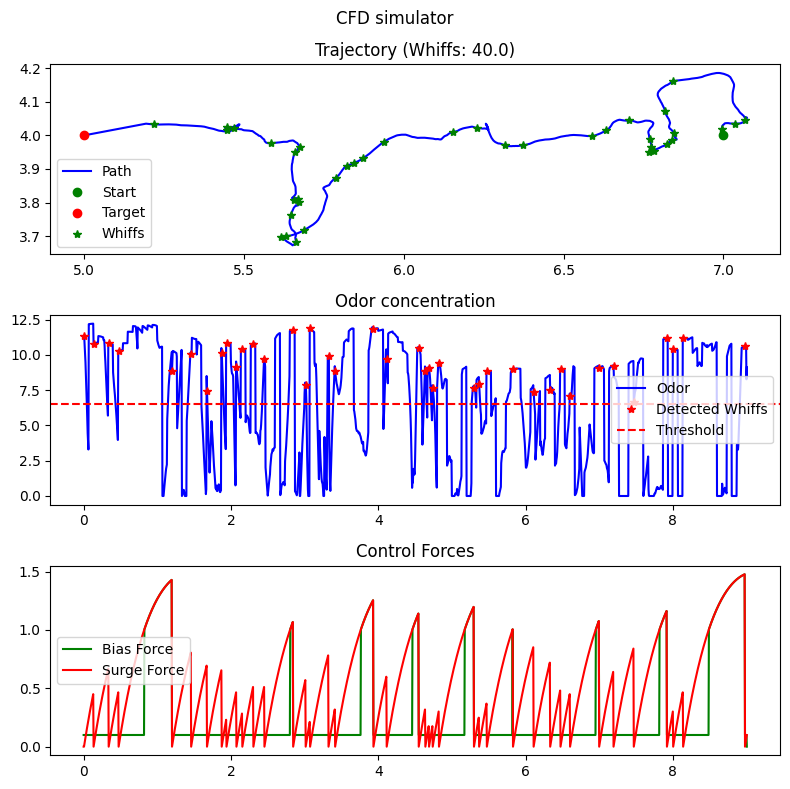

In [256]:
cfd = Cfd_rigolli(dirname="../data/rigolli/")
cfd_predictor = CfdOdorPredictor(cfd, scale_data)

bounds = [(5, 40), (0, 8)]
start_pos = np.array([7.0, 4.0])
target_pos = np.array([5.0, 4.0])

# Create surge-cast agent (same as before)
# Create surge-cast agent
surge_agent = SurgeCastAgent(
        tau=0.3,
        noise=3.0,
        bias=0.1,
        threshold=6.5,
        hit_trigger='peak',
        surge_amp=1.5,
        tau_surge=1.0,
        bounds=bounds
    )
    
target_weight = 0
plume_timeout = 10.0
closest_to_source = 0.2
sim_duration = 100.0

cfd_df=pd.DataFrame()
cfd_df = cfd_tracking(
    cfd_predictor, 
    bounds, 
    start_pos, 
    target_pos, 
    surge_agent, 
    target_weight, 
    plume_timeout, 
    closest_to_source, 
    sim_duration
)

In [257]:
# cfd_df.to_hdf('/home/gorilla/An/data/simulator/plot/tracking_figure/cfd8.h5', mode='w',key='cfd_df')

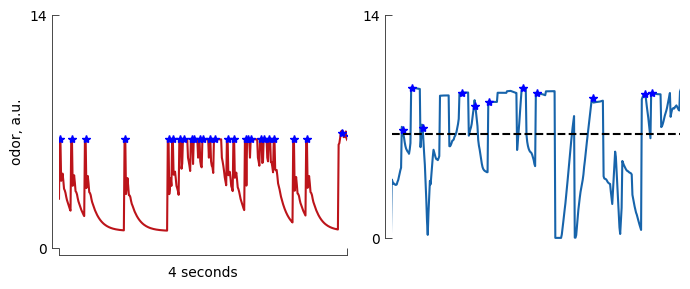

In [141]:
f,(ax1,ax2)=plt.subplots(1,2,figsize=(7,3))
lim=[3,5]

ax1.plot(osdf.time,osdf.odor, c='#bc141a')
ax1.set_xlim(lim)

whiff_idx = np.where(osdf["whiff"] == 1)[0]
if len(whiff_idx)>0:
        ax1.plot(osdf.time[whiff_idx], osdf.odor[whiff_idx], 'b*', label='Detected Whiffs')


mpl_functions.adjust_spines(ax1,['left','bottom'],
                            spine_locations={'left': 5,'bottom': 5}, 
                            smart_bounds=True,
                            xticks=lim,
                            yticks=[0,14],
                            linewidth=0.5)

ax1.set_xticklabels([])
ax1.set_xlabel('4 seconds')
ax1.set_ylabel('odor, a.u.')
ax2.plot(cfd_df.time,cfd_df.odor, c='#1764ab')
ax2.set_xlim(lim)
whiff_idx_cfd = np.where(cfd_df["whiff"] == 1)[0]
if len(whiff_idx_cfd)>0:
        ax2.plot(cfd_df.time[whiff_idx_cfd], cfd_df.odor[whiff_idx_cfd], 'b*', label='Detected Whiffs')
mpl_functions.adjust_spines(ax2,['left'],
                            spine_locations={'left': 5}, 
                            smart_bounds=True,
                            xticks=lim,
                            yticks=[0,14],
                            linewidth=0.5)



ax2.axhline(6.5,linestyle='--',c='black')

f.tight_layout()

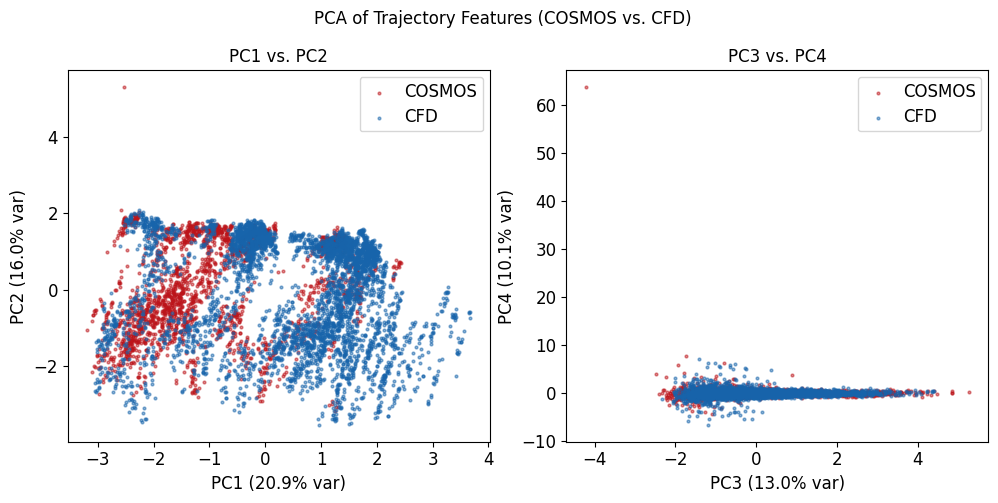

In [145]:

def compare_trajectories_extended(my_sim_df, cfd_df):
    """
    1) Extract the same set of features from each DataFrame.
    2) Combine them with a label.
    3) Scale the data, then do PCA with 4 components.
    4) Plot PC1 vs. PC2, and PC3 vs. PC4, using nice custom colors.
    """
    # ---------------------------
    # 1) Select the feature columns
    # ---------------------------
    feature_cols = [
        "vx", "vy", "speed", "acceleration",
        "heading_angle", "angular_velocity",
        "crosswind_dist", "upwind_dist",
        "dist_to_target", "time_since_whiff",
        "path_curvature"
    ]
    
    # Clean up infinities/NaNs
    for df in [my_sim_df, cfd_df]:
        df.replace([np.inf, -np.inf], np.nan, inplace=True)
        df.fillna(method='ffill', inplace=True)
        df.fillna(0, inplace=True)
        
    # Extract & fill
    my_sim_features = my_sim_df[feature_cols].fillna(0)
    cfd_features = cfd_df[feature_cols].fillna(0)

    # ---------------------------
    # 2) Combine with a 'source' label
    # ---------------------------
    my_sim_features["source"] = "COSMOS"
    cfd_features["source"] = "CFD"
    combined_df = pd.concat([my_sim_features, cfd_features], ignore_index=True)

    # We only do PCA on the numeric columns:
    X = combined_df[feature_cols].values
    labels = combined_df["source"].values

    # ---------------------------
    # 3) Scale + PCA(n_components=4)
    # ---------------------------
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    pca = PCA(n_components=4) 
    X_pca = pca.fit_transform(X_scaled)

    # Percent variance for the first 4 PCs
    var_explained = pca.explained_variance_ratio_ * 100
    pc1_var = var_explained[0]
    pc2_var = var_explained[1]
    pc3_var = var_explained[2]
    pc4_var = var_explained[3]

    # ---------------------------
    # 4) Plot PC1 vs PC2 & PC3 vs PC4
    # ---------------------------
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Choose some custom colors for each source
    color_map = {"COSMOS": "#bc141a",  # a nice red
                 "CFD":   "#1764ab"}  # a nice blue

    # Left subplot: PC1 vs. PC2
    for src_label in ["COSMOS", "CFD"]:
        idxs = (labels == src_label)
        axs[0].scatter(
            X_pca[idxs, 0], 
            X_pca[idxs, 1], 
            label=src_label,
            alpha=0.5,
            c=color_map[src_label], s=4
        )
    axs[0].set_xlabel(f"PC1 ({pc1_var:.1f}% var)")
    axs[0].set_ylabel(f"PC2 ({pc2_var:.1f}% var)")
    axs[0].legend()
    axs[0].set_title("PC1 vs. PC2")

    # Right subplot: PC3 vs. PC4
    for src_label in ["COSMOS", "CFD"]:
        idxs = (labels == src_label)
        axs[1].scatter(
            X_pca[idxs, 2], 
            X_pca[idxs, 3], 
            label=src_label,
            alpha=0.5,
            c=color_map[src_label], s=4
        )
    axs[1].set_xlabel(f"PC3 ({pc3_var:.1f}% var)")
    axs[1].set_ylabel(f"PC4 ({pc4_var:.1f}% var)")
    axs[1].legend()
    axs[1].set_title("PC3 vs. PC4")

    fig.suptitle("PCA of Trajectory Features (COSMOS vs. CFD)")
    fig.tight_layout()
    mpl_functions.set_fontsize(fig,12)
    return combined_df, X_pca

# Example usage:
if __name__ == "__main__":
    combined_df, xpca = compare_trajectories_extended(osdf, cfd_df)


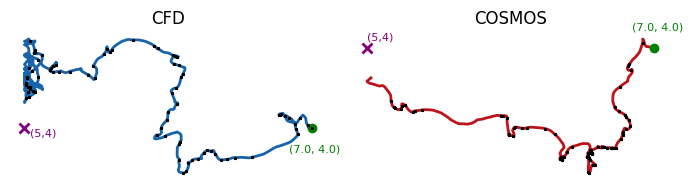

In [213]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 2))

c_map = {"COSMOS": "#bc141a",   # a nice red
        "CFD":   "#1764ab",     # a nice blue
        "odor_markers": "black",
        "target": "purple"}  


# 3) Right subplot: "CFD" trajectory
ax1.plot(cfd_df["x"][:-1], cfd_df["y"][:-1], c=c_map['CFD'], linewidth=2)
ax1.plot(cfd_df["x"].iloc[0], cfd_df["y"].iloc[0], 'go', label='Start')
ax1.plot(5, 4, 'x', color=c_map["target"], markersize=7, markeredgewidth=2, label='Target')

# Annotate start point
ax1.text(7.2,3.8, f'({cfd_df["x"].iloc[0]:.1f}, {cfd_df["y"].iloc[0]:.1f})', 
         fontsize=8, ha='right', va='bottom', color='green')

# Annotate target point (5,4)
ax1.text(5.04, 4, "(5,4)", fontsize=8, ha='left', va='top', color='purple')

whiff_idx_cfd = np.where(cfd_df["whiff"] == 1)[0]
if len(whiff_idx_cfd) > 0:
    ax1.plot(cfd_df["x"].iloc[whiff_idx_cfd],
            cfd_df["y"].iloc[whiff_idx_cfd],
            'k*', label='Whiffs', markersize=2)


# 2) Left subplot: "mySim" trajectory
ax2.plot(osdf["x"][:-1], osdf["y"][:-1], c=c_map['COSMOS'], linewidth=2)
ax2.plot(osdf["x"].iloc[0], osdf["y"].iloc[0], 'go', label='Start')
ax2.plot(5, 4, 'x', color=c_map["target"], markersize=7, markeredgewidth=2, label='Target')

# Annotate start point
ax2.text(7.2,4.1, f'({osdf["x"].iloc[0]:.1f}, {osdf["y"].iloc[0]:.1f})', 
         fontsize=8, ha='right', va='bottom', color='green')

# Annotate target point (5,4)
ax2.text(5, 4.1, "(5,4)", fontsize=8, ha='left', va='top', color='purple')

whiff_idx = np.where(osdf["whiff"] == 1)[0]
if len(whiff_idx) > 0:
    ax2.plot(osdf["x"].iloc[whiff_idx],
            osdf["y"].iloc[whiff_idx],
            'k*', label='Whiffs', markersize=2)

# Remove spines
for ax in [ax1, ax2]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

ax1.set_title("CFD")
ax2.set_title("COSMOS")

# Remove ticks and labels
for ax in [ax1, ax2]:
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])

fig.tight_layout()



#### Using Tsfresh

Extracting features from odor simulator data...


Feature Extraction: 100%|██████████| 80/80 [01:18<00:00,  1.02it/s]


Extracting features from CFD data...


Feature Extraction: 100%|██████████| 80/80 [01:26<00:00,  1.08s/it]


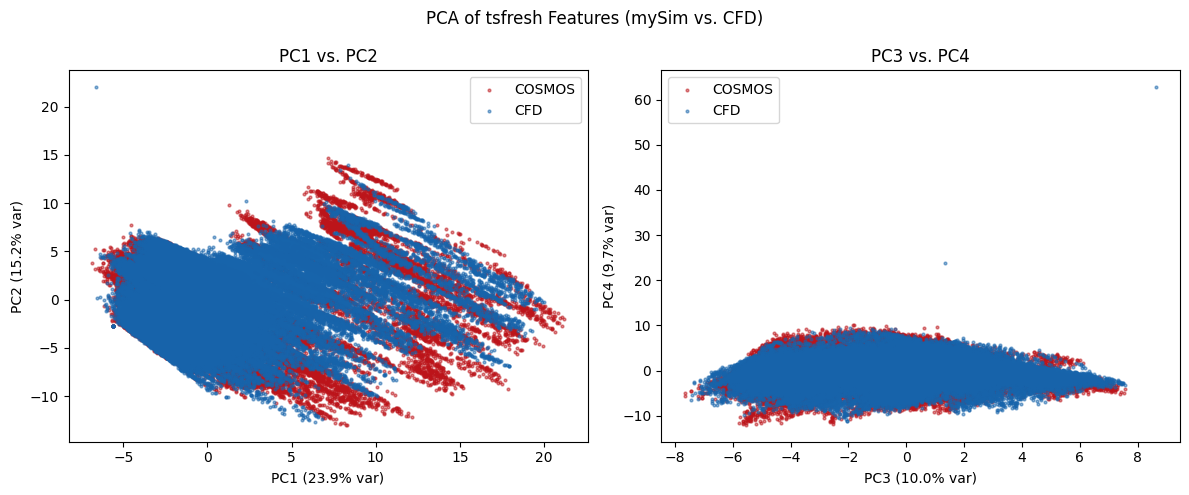


Top 10 features by absolute PCA loading:

PC1 top features:
upwind_dist__sum_values          0.196248
upwind_dist__median              0.196248
upwind_dist__mean                0.196248
upwind_dist__root_mean_square    0.196248
upwind_dist__maximum             0.196248
upwind_dist__absolute_maximum    0.196248
upwind_dist__minimum             0.196248
dist_to_target__sum_values       0.194411
dist_to_target__median           0.194411
dist_to_target__mean             0.194411
dtype: float64

PC2 top features:
crosswind_dist__sum_values          0.199312
crosswind_dist__median              0.199312
crosswind_dist__mean                0.199312
crosswind_dist__root_mean_square    0.199312
crosswind_dist__maximum             0.199312
crosswind_dist__absolute_maximum    0.199312
crosswind_dist__minimum             0.199312
dist_to_target__sum_values          0.142972
dist_to_target__median              0.142972
dist_to_target__mean                0.142972
dtype: float64

PC3 top features:
h

In [268]:
def compare_trajectories_tsfresh(osdf, cfd_df, n_components=4):
    """
    Compare trajectories using tsfresh feature extraction followed by PCA.
    
    Parameters:
    -----------
    osdf : DataFrame
        Odor simulator trajectory data.
    cfd_df : DataFrame
        CFD trajectory data.
    n_components : int
        Number of PCA components to compute.
        
    Returns:
    --------
    combined_df : DataFrame
        Combined features with labels.
    X_pca : ndarray
        PCA-transformed features.
    """
    # Make copies of the input DataFrames
    osdf = osdf.copy()
    cfd_df = cfd_df.copy()
    
    # Add trajectory IDs and source labels
    osdf['trajectory_id'] = ['os_' + str(i) for i in range(len(osdf))]
    cfd_df['trajectory_id'] = ['cfd_' + str(i) for i in range(len(cfd_df))]
    
    # Add a time column if not present
    if 'time' not in osdf.columns:
        osdf['time'] = np.arange(len(osdf))
    if 'time' not in cfd_df.columns:
        cfd_df['time'] = np.arange(len(cfd_df))
    
    # Feature columns to analyze
    feature_cols = [
        "vx", "vy", "speed", "acceleration",
        "heading_angle", "angular_velocity",
        "crosswind_dist", "upwind_dist",
        "dist_to_target", "time_since_whiff",
        "path_curvature"
    ]
    # feature_cols = [
    #     "odor", "vx", "vy"
    # ]
    
    # Ensure the features exist in osdf (assuming both DataFrames have the same set)
    existing_features = [col for col in feature_cols if col in osdf.columns]
    
    # Use the minimal feature configuration as a dictionary
    minimal_fc_parameters = MinimalFCParameters()
    
    # Extract tsfresh features for both datasets
    print("Extracting features from odor simulator data...")
    os_features = extract_features(
        osdf[['trajectory_id', 'time'] + existing_features],
        column_id='trajectory_id',
        column_sort='time',
        default_fc_parameters=minimal_fc_parameters
    )
    
    print("Extracting features from CFD data...")
    cfd_features = extract_features(
        cfd_df[['trajectory_id', 'time'] + existing_features],
        column_id='trajectory_id',
        column_sort='time',
        default_fc_parameters=minimal_fc_parameters
    )
    
    # Add source labels (these are non-numeric)
    os_features['source'] = 'COSMOS'
    cfd_features['source'] = 'CFD'
    
    # Combine features from both sources
    combined_df = pd.concat([os_features, cfd_features], ignore_index=True)
    
    # --- Fix: Remove non-numeric columns before imputation ---
    # Separate numeric features from non-numeric columns (like 'source')
    numeric_df = combined_df.drop(columns=['source'])
    # Impute missing numeric values
    numeric_df = impute(numeric_df)
    # Add back the non-numeric 'source' column
    combined_df = numeric_df.assign(source=combined_df['source'])
    
    # Separate features and labels for further analysis
    X = combined_df.drop('source', axis=1).values
    labels = combined_df['source'].values
    
    # Scale the features and apply PCA
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)
    
    # Calculate variance explained for visualization labels
    var_explained = pca.explained_variance_ratio_ * 100
    
    # Create visualizations
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    
    # Define custom colors
    color_map = {
        "COSMOS": "#bc141a",  # red
        "CFD": "#1764ab"     # blue
    }
    
    # Plot PC1 vs. PC2
    for src_label in ["COSMOS", "CFD"]:
        mask = (labels == src_label)
        axs[0].scatter(
            X_pca[mask, 0],
            X_pca[mask, 1],
            label=src_label,
            alpha=0.5,
            c=color_map[src_label],
            s=4
        )
    
    axs[0].set_xlabel(f"PC1 ({var_explained[0]:.1f}% var)")
    axs[0].set_ylabel(f"PC2 ({var_explained[1]:.1f}% var)")
    axs[0].legend()
    axs[0].set_title("PC1 vs. PC2")
    
    # Plot PC3 vs. PC4
    for src_label in ["COSMOS", "CFD"]:
        mask = (labels == src_label)
        axs[1].scatter(
            X_pca[mask, 2],
            X_pca[mask, 3],
            label=src_label,
            alpha=0.5,
            c=color_map[src_label],
            s=4
        )
    
    axs[1].set_xlabel(f"PC3 ({var_explained[2]:.1f}% var)")
    axs[1].set_ylabel(f"PC4 ({var_explained[3]:.1f}% var)")
    axs[1].legend()
    axs[1].set_title("PC3 vs. PC4")
    
    fig.suptitle("PCA of tsfresh Features (mySim vs. CFD)")
    plt.tight_layout()
    plt.show()
    
    # Print feature importance information
    print("\nTop 10 features by absolute PCA loading:")
    feature_names = combined_df.drop('source', axis=1).columns
    for i in range(n_components):
        pc_loadings = pd.Series(
            pca.components_[i],
            index=feature_names
        ).abs()
        print(f"\nPC{i+1} top features:")
        print(pc_loadings.nlargest(10))
    
    # Return combined features, PCA output, and labels for further analysis
    return combined_df, X_pca, labels

def compute_similarity_metrics(X_pca, labels):
    # Silhouette score
    sil_score = silhouette_score(X_pca, labels)
    print("Silhouette Score:", sil_score)
    
    # Normalized centroid distance
    unique_labels = np.unique(labels)
    centroids = {}
    spreads = {}
    for label in unique_labels:
        cluster_points = X_pca[labels == label]
        centroid = cluster_points.mean(axis=0)
        centroids[label] = centroid
        # Average Euclidean distance from points in the cluster to the centroid
        spreads[label] = np.mean(np.linalg.norm(cluster_points - centroid, axis=1))
    
    # Calculate the Euclidean distance between the two centroids (assuming exactly 2 clusters)
    centroid_distance = np.linalg.norm(centroids[unique_labels[0]] - centroids[unique_labels[1]])
    avg_spread = np.mean([spreads[label] for label in unique_labels])
    normalized_distance = centroid_distance / avg_spread
    print("Normalized Centroid Distance:", normalized_distance)
    
    return sil_score, normalized_distance

# Example usage:
# if __name__ == "__main__":    
    
#     combined_df, X_pca, labels = compare_trajectories_tsfresh(osdf, cfd_df)
#     sil_score, norm_centroid_distance = compute_similarity_metrics(X_pca, labels)

import glob

def load_and_combine(file_pattern):
    files = sorted(glob.glob(file_pattern))
    dfs = []
    for f in files:
        df = pd.read_hdf(f)
        # Drop the last row
        df = df.iloc[:-1]
        dfs.append(df)
    combined_df = pd.concat(dfs, ignore_index=True)
    return combined_df

if __name__ == "__main__":
    path = "/home/gorilla/An/data/simulator/plot/tracking_figure/"
    osdf_combined = load_and_combine(str(path)+"os*.h5")
    
    # Load and combine CFD simulator files: cfd1.h5, cfd2.h5, ..., cfd8.h5
    cfd_df_combined = load_and_combine(str(path)+"cfd*.h5")
    
    # Run the tsfresh feature extraction, PCA, and visualization
    combined_df, X_pca, labels = compare_trajectories_tsfresh(osdf_combined, cfd_df_combined)
    # plt.show()
    # Compute similarity metrics (silhouette score and normalized centroid distance)
    sil_score, norm_centroid_distance = compute_similarity_metrics(X_pca, labels)


In [269]:
path = "/home/gorilla/An/data/simulator/plot/tracking_figure/"
combined_df.to_hdf(str(path)+'tfresh_result_dataframe_all.h5', mode='w',key='combined_df')
np.save(str(path)+"X_pca_all.npy", X_pca)
np.save(str(path)+"labels_all.npy", labels)

In [1]:
# th=4.5
# query1 = 'odor>'+str(th)
# new_test_df1=pd.DataFrame()
# new_test_df1 = df_test.query(query1)
# new_test_df1.reset_index(inplace=True, drop=True)

# query2 = 'predicted_odor>'+str(th)
# new_test_df2=pd.DataFrame()
# new_test_df2 = df_test.query(query2)
# new_test_df2.reset_index(inplace=True, drop=True)

In [2]:
# f, ax = plt.subplots(2, 1, figsize=(4, 5))

# cax1 = ax[0].scatter(new_test_df1.distance_along_streakline, new_test_df1.nearest_from_streakline, c=new_test_df1.odor, s = 4, cmap='Blues', vmin=0, vmax=10)
# cax2 = ax[1].scatter(new_test_df2.distance_along_streakline, new_test_df2.nearest_from_streakline, c=new_test_df2.predicted_odor, s = 4, cmap='Blues', vmin=0, vmax=10)
# # cax3 = ax[2].scatter(new_test_df2.distance_along_streakline, new_test_df2.nearest_from_streakline, c=new_test_df2.whiff_predicted, s = 4, cmap='Blues', vmin=0, vmax=1)
# # ylim=(-15,25)

# ax[0].set_title('True Odor - NWhiffs='+str(len(new_test_df1)))
# ax[1].set_title('Predicted Odor - NWhiffs='+str(len(new_test_df2)))
# ax[1].set_xlabel('x, m')
# ax[1].set_ylabel('y, m')

# cb1=plt.colorbar(cax1)
# cb2=plt.colorbar(cax2)

# cb1.set_label('Odor, a.u.',labelpad=0)
# cb2.set_label('Odor, a.u.',labelpad=0)


# cb1.set_ticks([0,10])
# cb2.set_ticks([0,10])
# # cb3.set_ticks([0, 1])
# for i in range(2):
#     # mpl_functions.adjust_spines(ax[i],['left','bottom'],
#     #                         spine_locations={'left': 1}, 
#     #                         smart_bounds=True,
#     #                         xticks=[0,25,50],
#     #                         yticks=[0,8],
#     #                         linewidth=0.5)
#     # mpl_functions.set_fontsize(ax[i],11)
#     mpl_functions.adjust_spines(ax[i],['left','bottom'],
#                         spine_locations={'left': 1}, 
#                         smart_bounds=True,
#                         xticks=[0,25,50],
#                         yticks=[-20,20],
#                         linewidth=0.5)
#     mpl_functions.set_fontsize(ax[i],11)

# f.tight_layout()

In [3]:
# # Number of bins and plot limits
# n_bins = 20
# # Actual Whiff Data
# df_actual = new_test_df1.copy()
# bins = np.linspace(0, df_actual['distance_from_source'].max(), n_bins + 1)
# df_actual['distance_bin'] = pd.cut(df_actual['distance_from_source'], bins=bins)

# whiff_counts_actual = df_actual.groupby('distance_bin').size()
# mean_concentrations_actual = df_actual.groupby('distance_bin')['odor'].mean()
# bin_centers_actual = (bins[:-1] + bins[1:]) / 2

# # Normalize actual whiff counts
# whiff_counts_actual_normalized = whiff_counts_actual / whiff_counts_actual.max()

# # Predicted Whiff Data
# df_predicted = new_test_df2.copy()
# bins_predicted = np.linspace(0, df_predicted['distance_from_source'].max(), n_bins + 1)
# df_predicted['distance_bin'] = pd.cut(df_predicted['distance_from_source'], bins=bins_predicted)

# whiff_counts_predicted = df_predicted.groupby('distance_bin').size()
# mean_concentrations_predicted = df_predicted.groupby('distance_bin')['predicted_odor'].mean()
# bin_centers_predicted = (bins_predicted[:-1] + bins_predicted[1:]) / 2

# # Normalize predicted whiff counts
# whiff_counts_predicted_normalized = whiff_counts_predicted / whiff_counts_predicted.max()

# # Create the subplots
# f, ax = plt.subplots(2, 1, figsize=(5, 4))

# # Plot for Actual Whiff Data
# norm_actual = plt.Normalize(4, 10)
# colors_actual = plt.cm.viridis(norm_actual(mean_concentrations_actual))
# bars_actual = ax[0].bar(bin_centers_actual, whiff_counts_actual_normalized, width=(bins[1] - bins[0]), edgecolor='black', color=colors_actual)

# divider_actual = make_axes_locatable(ax[0])
# cax_actual = divider_actual.append_axes("right", size="5%", pad=0.05)
# sm_actual = plt.cm.ScalarMappable(cmap='viridis', norm=norm_actual)
# sm_actual.set_array([])
# cbar_actual = plt.colorbar(sm_actual, cax=cax_actual)
# cbar_actual.set_label('Mean Concentration')

# ax[0].set_xlabel('Distance from Source')
# ax[0].set_ylabel('No.(whiffs)')
# ax[0].set_title('Actual Whiff')
# # ax[0].set_ylim(ylim)
# ax[0].set_xlim(0, 50)

# # Plot for Predicted Whiff Data
# norm_predicted = plt.Normalize(4, 10)
# colors_predicted = plt.cm.viridis(norm_predicted(mean_concentrations_predicted))
# bars_predicted = ax[1].bar(bin_centers_predicted, whiff_counts_predicted_normalized, width=(bins_predicted[1] - bins_predicted[0]), edgecolor='black', color=colors_predicted)

# divider_predicted = make_axes_locatable(ax[1])
# cax_predicted = divider_predicted.append_axes("right", size="5%", pad=0.05)
# sm_predicted = plt.cm.ScalarMappable(cmap='viridis', norm=norm_predicted)
# sm_predicted.set_array([])
# cbar_predicted = plt.colorbar(sm_predicted, cax=cax_predicted)
# cbar_predicted.set_label('Mean Concentration')

# ax[1].set_xlabel('Distance from Source')
# ax[1].set_ylabel('No.(Whiffs)')
# ax[1].set_title('Predicted Whiff')
# ylim = (0, 1)
# # ax[1].set_ylim(ylim)
# ax[1].set_xlim(0, 50)

# # Adjust the layout
# f.tight_layout()



In [17]:
cfd_df = cfd_df[:-1]
cfd_df['distance_from_source']=cfd_df.dist_to_target

/tmp/ipykernel_330554/335038662.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cfd_df['distance_from_source']=cfd_df.dist_to_target


In [18]:
osdf = osdf[:-1]
osdf['distance_from_source']=osdf.dist_to_target

In [20]:
osdf['predicted_odor']=osdf.odor

In [21]:
new_test_df1=cfd_df.copy()
new_test_df2=osdf.copy()

def cal_stat(df,idx,df2):
    osc.avg_distance(df,idx,df2)
    osc.mean_conc(df,idx,df2)
    osc.whiff_blank_duration(df,idx,df2)
    osc.std_whiff(df,idx,df2)
    osc.mean_avg(df,idx,df2)
    osc.encounter_frequency(df,idx,df2,1,2)
    osc.mean_t(df,idx,df2)

def cal_stat_predicted(df,idx,df2):
    osc.avg_distance(df,idx,df2)
    osc.predicted_mean_conc(df,idx,df2)
    osc.whiff_blank_duration(df,idx,df2)
    osc.std_whiff_predicted(df,idx,df2)
    osc.mean_avg_predicted(df,idx,df2)
    osc.encounter_frequency_predicted(df,idx,df2,1,2)
    osc.mean_t(df,idx,df2)
th = 6.5
np.seterr(divide='ignore')
index = osc.get_index(new_test_df1.odor,th)
index_predicted = osc.get_index(new_test_df2.odor,th)
fdf1 = pd.DataFrame()
fdf_predicted = pd.DataFrame()

cal_stat(new_test_df1,index,fdf1)
cal_stat_predicted(new_test_df2,index_predicted, fdf_predicted)

fdf1.keys()

Index(['avg_dist_from_source', 'log_avg_dist_from_source',
       'mean_concentration', 'length_of_encounter', 'odor_intermittency',
       'log_whiff', 'log_blank', 'std_whiff', 'whiff_ma', 'wf', 'mean_time'],
      dtype='object')

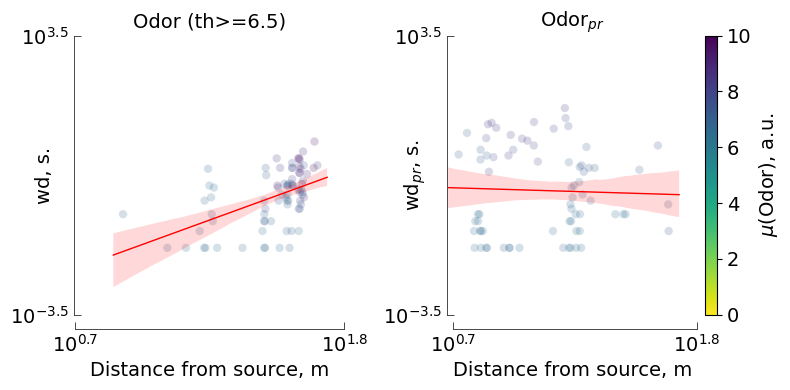

In [29]:
### WHIFF DURATION
f,(ax1,ax2)=plt.subplots(1,2,figsize=(8,4))
var = ax1.scatter(fdf1.log_avg_dist_from_source,fdf1.log_whiff, c=fdf1.mean_concentration, cmap='viridis_r',edgecolors='none', 
                 alpha=0.2,vmin=0,vmax=10)
ax1.set_ylabel('$\mu$(WC), a.u.')

g1 = sns.regplot(x=fdf1.log_avg_dist_from_source,y=fdf1.log_whiff , data=fdf1,
            ax=ax1, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
g1.set(xlabel=None, ylabel=None)

# divider = make_axes_locatable(ax1)
# cax = divider.append_axes('right', size='5%', pad=0.08)
# cbar=f.colorbar(var, cax=cax, orientation = 'vertical')
# cbar.solids.set(alpha=1)
# cbar.set_label('$\mu$(WC), a.u.')

ax1.set_xlabel('Distance from source, m')
ax1.set_ylabel('wd, s.')
ax1.set_title('Odor (th>='+str(th)+')')
ax1.yaxis.set_label_coords(-0.08, 0.5)

u=ax2.scatter(fdf_predicted.log_avg_dist_from_source,
              fdf_predicted.log_whiff, 
              c=fdf_predicted.mean_concentration, cmap='viridis_r',edgecolors='none', 
                 alpha=0.2, vmin=0,vmax=10)

g2 = sns.regplot(x=fdf_predicted.log_avg_dist_from_source,y=fdf_predicted.log_whiff , data=fdf_predicted,
            ax=ax2, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
g2.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax2)
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(u, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(Odor), a.u.')

ax2.set_xlabel('Distance from source, m')
ax2.set_title('Odor$_{pr}$')
ax2.set_ylabel('wd$_{pr}$, s.')
ax2.yaxis.set_label_coords(-0.08, 0.5)
mpl_functions.adjust_spines(ax1,['left','bottom'],
                            spine_locations={'left': 1}, 
                            smart_bounds=True,
                            xticks=[-0.7,0.7],
                            yticks=[-3.5,1.5],
                            linewidth=0.5)
mpl_functions.adjust_spines(ax2,['left','bottom'],
                            spine_locations={'left': 1}, 
                            smart_bounds=True,
                            xticks=[-0.7,0.7],
                            yticks=[-3.5,1.5],
                            linewidth=0.5)
ax1.set_yticklabels([r'$10^{-3.5}$',r'$10^{3.5}$'])
ax1.set_xticklabels([r'$10^{0.7}$',r'$10^{1.8}$'])
ax2.set_yticklabels([r'$10^{-3.5}$',r'$10^{3.5}$'])
ax2.set_xticklabels([r'$10^{0.7}$',r'$10^{1.8}$'])

mpl_functions.set_fontsize(f, 14)
f.tight_layout()


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 8944.41it/s]


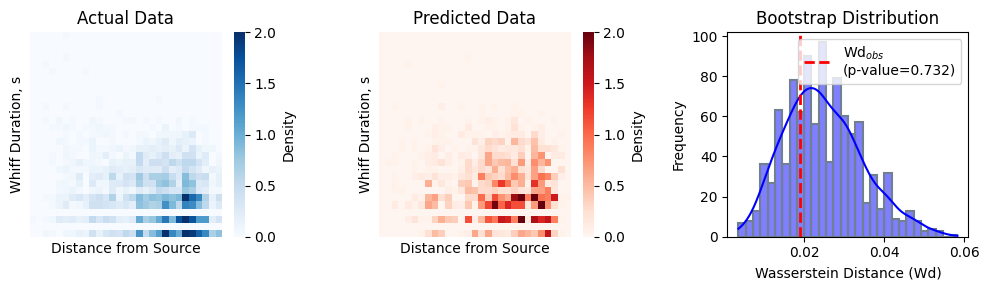

In [10]:
## Duration:
osc.wd_cal(fdf1.log_avg_dist_from_source, fdf1.log_whiff, fdf_predicted.log_avg_dist_from_source, fdf_predicted.log_whiff, 'Whiff Duration, s', 0,2)

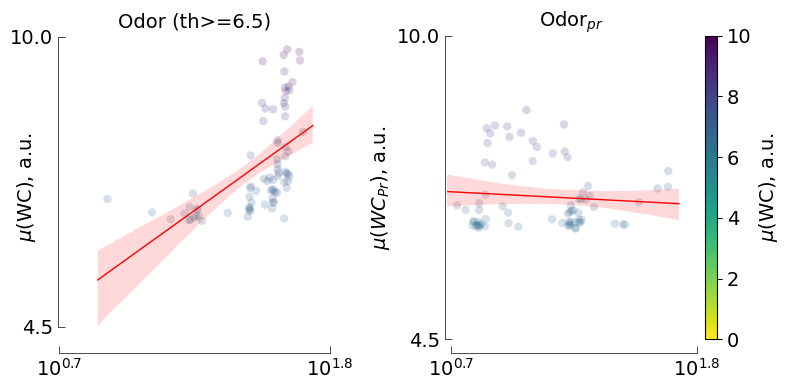

In [35]:
### Whiff concentration
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# Plot for actual odor
var1 = ax1.scatter(fdf1.log_avg_dist_from_source, fdf1.mean_concentration, c=fdf1.mean_concentration, cmap='viridis_r', edgecolors='none',
                   alpha=0.2, vmin=0, vmax=10)


g1 = sns.regplot(x=fdf1.log_avg_dist_from_source, y=fdf1.mean_concentration, data=fdf1,
                 ax=ax1, line_kws={'color': 'red', 'linewidth': 1}, scatter=False, truncate=False)
g1.set(xlabel=None, ylabel=None)

# divider = make_axes_locatable(ax1)
# cax = divider.append_axes('right', size='5%', pad=0.08)
# cbar = f.colorbar(var1, cax=cax, orientation='vertical')
# cbar.solids.set(alpha=1)
# cbar.set_label('$\mu$(WC), a.u.')

# ax1.set_xlabel('Distance from source (log), m')
ax1.set_title('Odor (th>=' + str(th) + ')')
ax1.yaxis.set_label_coords(-0.08, 0.5)

# Plot for predicted odor
var2 = ax2.scatter(fdf_predicted.log_avg_dist_from_source, fdf_predicted.mean_concentration, c=fdf_predicted.mean_concentration,
                   cmap='viridis_r', edgecolors='none', alpha=0.2, vmin=0, vmax=10)

g2 = sns.regplot(x=fdf_predicted.log_avg_dist_from_source, y=fdf_predicted.mean_concentration, data=fdf_predicted,
                 ax=ax2, line_kws={'color': 'red', 'linewidth': 1}, scatter=False, truncate=False)
g2.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax2)
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1 = f.colorbar(var2, cax=cax1, orientation='vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC), a.u.')

# ax2.set_xlabel('Distance from source (log), m')
ax2.set_title('Odor$_{pr}$')
ax1.set_ylabel('$\mu$(WC), a.u.')
ax2.set_ylabel('$\mu(WC_{Pr})$, a.u.')
# Adjust spines for both plots
mpl_functions.adjust_spines(ax1, ['left', 'bottom'],
                            spine_locations={'left': 1},
                            smart_bounds=True,
                            xticks=[-0.7, 0.7],
                            yticks=[4.5, 10],
                            linewidth=0.5)
mpl_functions.adjust_spines(ax2, ['left', 'bottom'],
                            spine_locations={'left': 1},
                            smart_bounds=True,
                            xticks=[-0.7, 0.7],
                            yticks=[4.5, 10],
                            linewidth=0.5)

# Set custom tick labels
# ax1.set_yticklabels([r'$4$', r'$10$'])
ax1.set_xticklabels([r'$10^{0.7}$', r'$10^{1.8}$'])
# ax2.set_yticklabels([r'$4$', r'$10$'])
ax2.set_xticklabels([r'$10^{0.7}$', r'$10^{1.8}$'])

# Set font size and layout
mpl_functions.set_fontsize(f, 14)
f.tight_layout()


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 9066.45it/s]


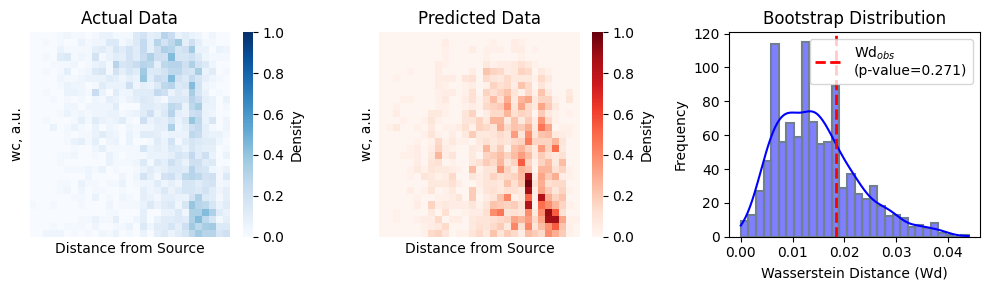

In [12]:
osc.wd_cal(fdf1.log_avg_dist_from_source, fdf1.mean_concentration, fdf_predicted.log_avg_dist_from_source, fdf_predicted.mean_concentration, 'wc, a.u.',0,1)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 8414.12it/s]


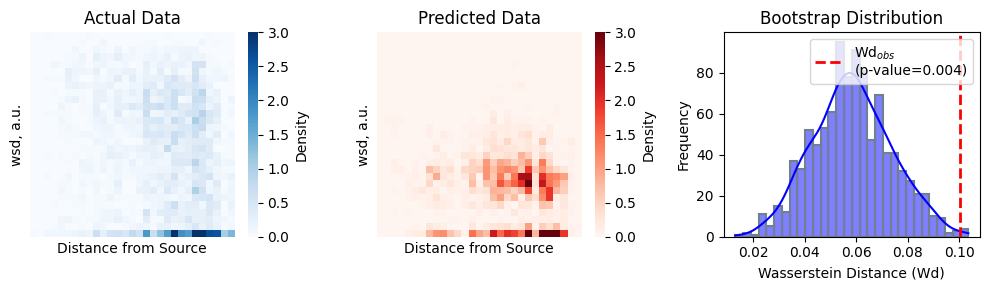

In [13]:
osc.wd_cal(fdf1.log_avg_dist_from_source, fdf1.std_whiff, fdf_predicted.log_avg_dist_from_source, fdf_predicted.std_whiff, 'wsd, a.u.', 0,3)

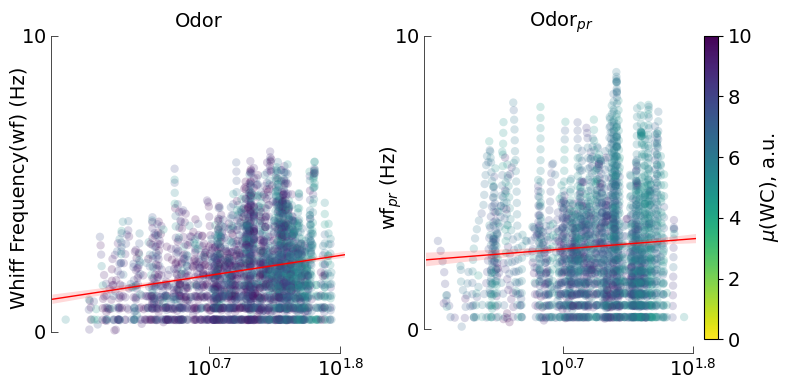

In [14]:
### WHIFF FREQUENCY
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# Plot for actual odor
var = ax1.scatter(fdf1.log_avg_dist_from_source, fdf1.wf, c=fdf1.mean_concentration, cmap='viridis_r', edgecolors='none',
                  alpha=0.2, vmin=0, vmax=10)
ax1.set_ylabel('Whiff Frequency (Hz)')

g1 = sns.regplot(x=fdf1.log_avg_dist_from_source, y=fdf1.wf, data=fdf1,
                 ax=ax1, line_kws={'color': 'red', 'linewidth': 1}, scatter=False, truncate=False)
g1.set(xlabel=None, ylabel=None)
ax1.set_title('Odor')

# Plot for predicted odor
u = ax2.scatter(fdf_predicted.log_avg_dist_from_source, fdf_predicted.wf, c=fdf_predicted.mean_concentration,
                cmap='viridis_r', edgecolors='none', alpha=0.2, vmin=0, vmax=10)

g2 = sns.regplot(x=fdf_predicted.log_avg_dist_from_source, y=fdf_predicted.wf, data=fdf_predicted,
                 ax=ax2, line_kws={'color': 'red', 'linewidth': 1}, scatter=False, truncate=False)
g2.set(xlabel=None, ylabel=None)

# Add color bar only for the predicted odor plot
divider = make_axes_locatable(ax2)
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1 = f.colorbar(u, cax=cax1, orientation='vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC), a.u.')

# Set the titles and labels
ax2.set_title('Odor$_{pr}$')
ax1.yaxis.set_label_coords(-0.08, 0.5)
ax2.yaxis.set_label_coords(-0.08, 0.5)
ax1.set_ylabel('Whiff Frequency(wf) (Hz)')
ax2.set_ylabel('wf$_{pr}$ (Hz)')

# Adjust spines for both plots
mpl_functions.adjust_spines(ax1, ['left', 'bottom'],
                            spine_locations={'left': 1},
                            smart_bounds=True,
                            xticks=[0.7, 1.8],
                            yticks=[0,12],
                            linewidth=0.5)
mpl_functions.adjust_spines(ax2, ['left', 'bottom'],
                            spine_locations={'left': 1},
                            smart_bounds=True,
                            xticks=[0.7, 1.8],
                            yticks=[0, 12],
                            linewidth=0.5)

# Set custom tick labels
ax1.set_yticklabels([r'$0$', r'$10$'])
ax1.set_xticklabels([r'$10^{0.7}$', r'$10^{1.8}$'])
ax2.set_yticklabels([r'$0$', r'$10$'])
ax2.set_xticklabels([r'$10^{0.7}$', r'$10^{1.8}$'])

# Set font size and layout
mpl_functions.set_fontsize(f, 14)
f.tight_layout()

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 10149.61it/s]


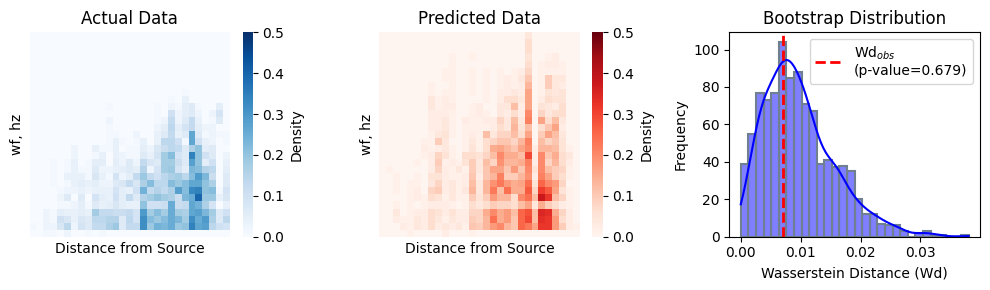

In [15]:
osc.wd_cal(fdf1.log_avg_dist_from_source, fdf1.wf, fdf_predicted.log_avg_dist_from_source, fdf_predicted.wf, 'wf, hz',0,0.5)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 9865.56it/s]


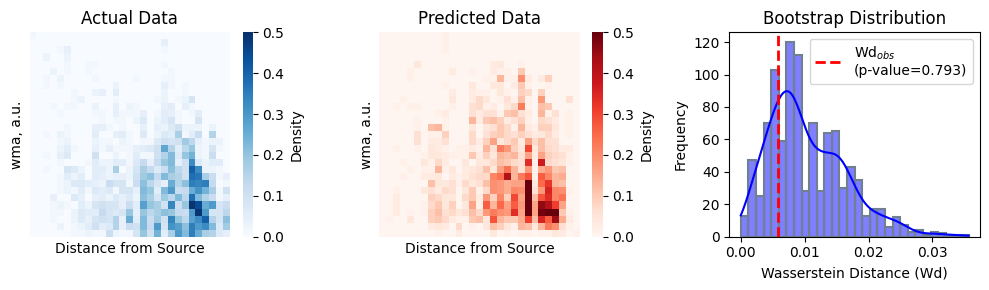

In [16]:
osc.wd_cal(fdf1.log_avg_dist_from_source, fdf1.whiff_ma, fdf_predicted.log_avg_dist_from_source, fdf_predicted.whiff_ma, 'wma, a.u.', 0,0.5)